In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# **Исходные данные**

In [2]:
initial_data = pd.read_excel('/content/Nedvig.xls')
initial_data.head()

,Номер,Район,Число комнат,Тип дома,Индикаторная переменная,Общая,Жилая,Кухня,"Цена, тыс. руб."
0,1,ЮМР,1,блочный,0,40.0,20.0,10.0,1596.0
1,2,ЮМР,2,блочный,0,60.0,32.0,10.0,1876.0
2,3,ЮМР,2,блочный,0,77.0,40.0,16.0,3500.0
3,4,ЮМР,3,блочный,0,66.0,42.0,9.0,2074.8
4,5,ЮМР,3,блочный,0,70.0,44.0,10.0,2156.0


In [0]:
# Вырезаем первую колонку "Номер", тк она неинформативна
initial_data = initial_data.iloc[:, 1:]

# Для удобства переименовываем признаки на англ
initial_data.columns = [
                        'Area', 
                        'Rooms_num', 
                        'Building_type', 
                        'Indicator',
                        'Square',
                        'Square_living',
                        'Square_kitchen',
                        'Price',
                        ]

In [4]:
print(initial_data.shape)
print(initial_data.dtypes)

(1573, 8)
Area               object
Rooms_num           int64
Building_type      object
Indicator           int64
Square            float64
Square_living     float64
Square_kitchen    float64
Price             float64
dtype: object


In [5]:
initial_data.describe()

,Rooms_num,Indicator,Square,Square_living,Square_kitchen,Price
count,1573.000000,1573.000000,1573.000000,1569.000000,1567.000000,1573.000000
mean,2.364272,0.335029,62.814533,37.211026,10.187747,2075.020919
std,1.058190,0.472151,25.827560,16.908300,4.176530,1369.953515
min,1.000000,0.000000,11.000000,8.000000,0.000000,270.000000
25%,2.000000,0.000000,44.000000,24.000000,7.000000,1449.900000
50%,2.000000,0.000000,60.000000,34.000000,9.000000,1817.100000
75%,3.000000,1.000000,74.000000,45.000000,12.000000,2397.600000
max,7.000000,1.000000,226.000000,120.000000,44.000000,41706.898000


In [6]:
initial_data.isna().sum()

Area                0
Rooms_num           0
Building_type     159
Indicator           0
Square              0
Square_living       4
Square_kitchen      6
Price               0
dtype: int64

# **Анализ на основе непрерывных признаков**

In [7]:
data = initial_data.copy()
data = data[['Rooms_num', 'Square', 'Square_living', 'Square_kitchen', 'Price']]
data.head()

,Rooms_num,Square,Square_living,Square_kitchen,Price
0,1,40.0,20.0,10.0,1596.0
1,2,60.0,32.0,10.0,1876.0
2,2,77.0,40.0,16.0,3500.0
3,3,66.0,42.0,9.0,2074.8
4,3,70.0,44.0,10.0,2156.0


## Построение olap-куба (зависимость средней цены от количества комнат)

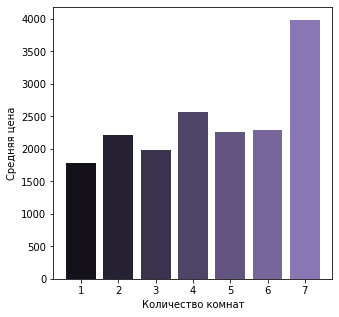

In [8]:
def visualize_olap_cube(df):
  """
  """
  rooms_prices = {}
  colors = ['']

  for num in data.Rooms_num.unique():
    avg = data['Price'][data.Rooms_num == num].mean()
    rooms_prices[num] = avg
  
  colors = [(c/13, c/15, c/10) for c in rooms_prices.keys()]

  plt.figure(figsize=(5,5))
  ax = plt.gca()
  ax.bar(rooms_prices.keys(), rooms_prices.values(), color=colors)
  ax.set_xlabel('Количество комнат')
  ax.set_ylabel('Средняя цена')

  
visualize_olap_cube(df=data)


# Рассматриваем только однокомнатные квартиры
## Обработка выбросов и пропусков

In [9]:
df = data.copy()
df = df[
        ['Square', 'Square_living', 'Square_kitchen', 'Price']
        ][df['Rooms_num'] == 1].reset_index(drop=True)
df.head()

,Square,Square_living,Square_kitchen,Price
0,40.0,20.0,10.0,1596.0
1,37.0,17.0,8.0,1344.0
2,38.0,18.0,9.0,1148.0
3,27.0,14.0,6.0,686.0
4,30.0,17.0,6.0,1008.0


In [10]:
df.shape

(391, 4)

In [0]:
# Заполняем пропуски медианой
df = df.fillna(value = df.quantile())

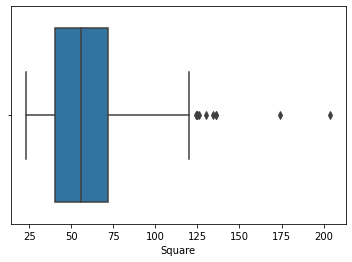

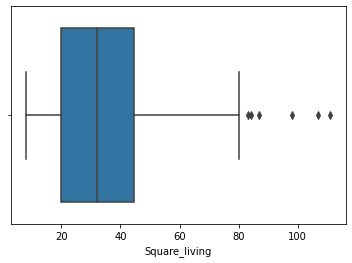

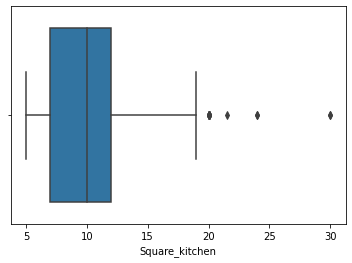

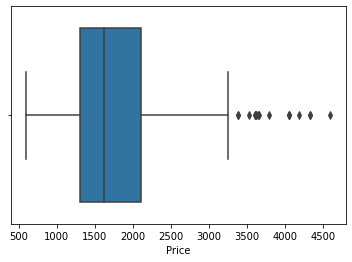

In [12]:
for col in df.columns:
  plt.figure(figsize=(6,4))
  sns.boxplot(x=df[col])

In [14]:
def find_outliners(df):
  """
  Метод для нахождения выбросов по методу Д.Тьюки
  """

  cols_indexes = {}
  all_indexes = []
  for col in df.columns:
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    LIF = df[col].quantile(q=0.25) - 1.5*IQR
    UIF = df[col].quantile(q=0.75) + 1.5*IQR

    indexes = []
    for i, value in enumerate(df[col]):
      if value < LIF or value > UIF:
        indexes.append(i)
        all_indexes.append(i)

    cols_indexes[col] = indexes

  return cols_indexes, set(all_indexes)

_, all_ind = find_outliners(df=df)
print(len(all_ind))

36


(355, 4)

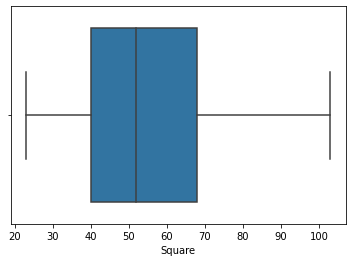

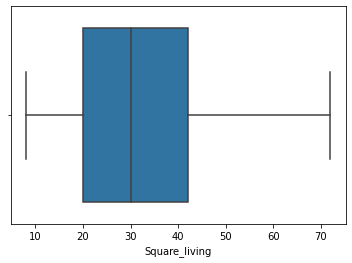

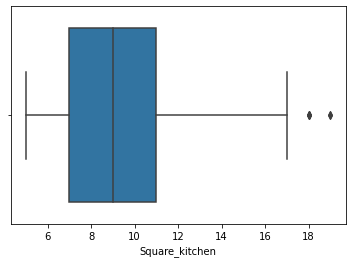

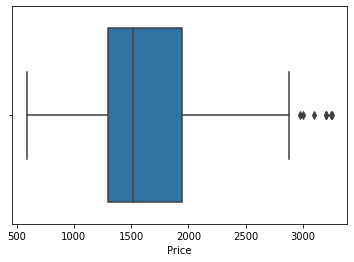

In [15]:
# Удаляем все найденные выбросы
df = df.drop(all_ind)

for col in df.columns:
  plt.figure(figsize=[6,4])
  sns.boxplot(x=df[col])

df.shape

# Корреляция

In [0]:
df.corr()

,Square,Square_living,Square_kitchen,Price
Square,1.000000,0.909997,0.272263,0.814525
Square_living,0.909997,1.000000,-0.007071,0.794101
Square_kitchen,0.272263,-0.007071,1.000000,0.168324
Price,0.814525,0.794101,0.168324,1.000000


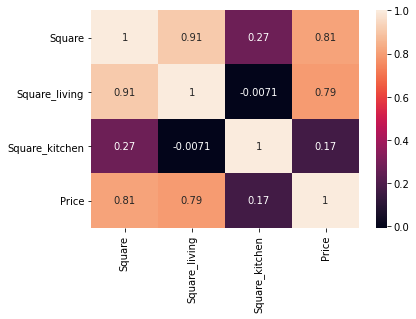

In [16]:
sns.heatmap(df.corr(), yticklabels=True, xticklabels=True, annot=True)

In [19]:
df.describe()

,Square,Square_living,Square_kitchen,Price
count,355.000000,355.000000,355.000000,355.000000
mean,54.280282,31.460563,9.486197,1630.456051
std,17.114759,13.025500,2.878413,493.875473
min,23.000000,8.000000,5.000000,594.000000
25%,40.000000,20.000000,7.000000,1298.000000
50%,52.000000,30.000000,9.000000,1512.000000
75%,68.000000,42.000000,11.000000,1944.000000
max,103.000000,72.000000,19.000000,3250.800000


# Линейная регрессия: цена в зависимости от общей площади и площади кухни

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [0]:
df_ = df.copy()
Y = df_['Price']
X = df_[['Square', 'Square_kitchen']]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

In [38]:
lin_reg = LinearRegression(fit_intercept=True, normalize=True)
lin_reg.fit(X_train, Y_train)
Y_pred = lin_reg.predict(X_test)

print(f'Коэффициенты: {lin_reg.coef_}, {lin_reg.intercept_}')
print(f'Средняя абсолютная ошибка: {mean_absolute_error(Y_test, Y_pred)}')
print(f'Коэффициент детерминации: {r2_score(Y_test, Y_pred)}')

Коэффициенты: [22.65410248 -8.60081541], 484.95505592183235
Средняя абсолютная ошибка: 198.48214650092757
Коэффициент детерминации: 0.7110136103105775


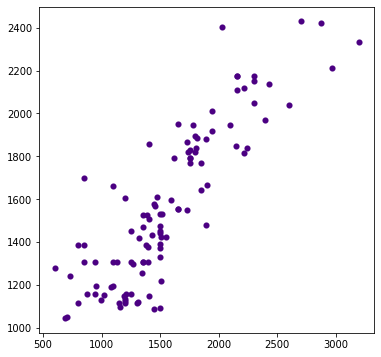

In [39]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test, Y_pred, color='indigo', linewidth=0.1)

# Нейросетевые модели

In [0]:
df_ = df.copy()
Y = df_['Price']
X = df_[['Square', 'Square_kitchen', 'Square_living']]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

In [158]:
import torch

x_train, y_train, x_test, y_test = map(
    torch.tensor, (X_train.values.astype('float32'), Y_train.values.astype('float32'), 
                   X_test.values.astype('float32'), Y_test.values.astype('float32'))
)
print(x_train.size(), y_train.size(), x_test.size(), y_test.size())

torch.Size([248, 3]) torch.Size([248]) torch.Size([107, 3]) torch.Size([107])


In [0]:
input_size = x_train.size()[1]
output_size = 1
n_hidden_neurons = 4

In [0]:
y_train = y_train.unsqueeze(1)

In [0]:
class LinNet(torch.nn.Module):
  def __init__(self, input_size, n_hidden_neurons, output_size):
    super().__init__()

    self.linear_input = torch.nn.Linear(
        input_size, 
        n_hidden_neurons,
        bias=True,
        )
    # self.act = torch.nn.ReLU()
    self.linear_output = torch.nn.Linear(
        n_hidden_neurons, 
        output_size,
        )

  def forward(self, x):
    x = self.linear_input(x)
    # x = self.act(x)
    x = self.linear_output(x)
    return x


In [183]:
net = LinNet(input_size=input_size, n_hidden_neurons=n_hidden_neurons, output_size=output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())



for epoch_index in range(4000): 

    y_pred = net.forward(x_train)
    loss_value = loss_fn(y_pred, y_train)
    loss_value.backward()
    optimizer.step()
    if epoch_index%100 == 0:
      print('epoch {}, loss {}'.format(epoch_index, loss_value.data))

epoch 0, loss 3011527.25
epoch 100, loss 2969772.25
epoch 200, loss 2894276.5
epoch 300, loss 2735583.5
epoch 400, loss 2490620.75
epoch 500, loss 2163616.5
epoch 600, loss 1762280.0
epoch 700, loss 1330851.25
epoch 800, loss 914470.8125
epoch 900, loss 553986.5625
epoch 1000, loss 283310.4375
epoch 1100, loss 127152.4609375
epoch 1200, loss 98334.7890625
epoch 1300, loss 194532.125
epoch 1400, loss 394543.28125
epoch 1500, loss 654715.3125
epoch 1600, loss 907820.125
epoch 1700, loss 1070980.25
epoch 1800, loss 1074844.125
epoch 1900, loss 911798.25
epoch 2000, loss 650835.4375
epoch 2100, loss 388923.9375
epoch 2200, loss 197564.96875
epoch 2300, loss 104227.5390625
epoch 2400, loss 101980.0703125
epoch 2500, loss 167542.96875
epoch 2600, loss 274501.15625
epoch 2700, loss 399476.28125
epoch 2800, loss 523761.1875
epoch 2900, loss 632898.5
epoch 3000, loss 715636.125
epoch 3100, loss 763013.0625
epoch 3200, loss 768076.9375
epoch 3300, loss 726752.75
epoch 3400, loss 640127.75
epoch 

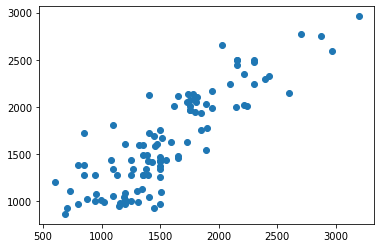

In [184]:
with torch.no_grad():
  y_pred = net(x_test)

plt.scatter(y_test, y_pred)

In [185]:
y_test[:5], y_pred[:5]

(tensor([1755.0000, 1350.0000, 1431.0000, 2970.0000, 2300.3999]),
 tensor([[2077.7822],
         [1600.8512],
         [1414.2269],
         [2589.6218],
         [2241.7317]]))